In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


A extension introduction tutorial to fMRI decoding making use of PCA to filter Noise
==========================================

Here is a simple tutorial on decoding with nilearn. It reproduces the
Haxby 2001 study on a face vs cat discrimination task in a mask of the
ventral stream.

This tutorial is meant as an introduction to the various steps of a
decoding analysis.

It is not a minimalistic example, as it strives to be didactic. It is not
meant to be copied to analyze new data: many of the steps are unecessary.
    :depth: 1





Retrieve and load the fMRI data from the  Haxby study
-----------------------------------------------------

First download the data
.......................

The :func:`nilearn.datasets.fetch_haxby` function will download the
Haxby dataset if not present on the disk, in the nilearn data directory.
It can take a while to download about 310 Mo of data from the Internet.



In [2]:
from nilearn import datasets
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
# 'func' is a list of filenames: one for each subject
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      fmri_filename)  # 4D data

/Users/brianwahome254/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


First subject functional nifti images (4D) are at: /Users/brianwahome254/nilearn_data/haxby2001/subj2/bold.nii.gz


Convert the fMRI volume's to a data matrix
..........................................

We will use the :class:`nilearn.input_data.NiftiMasker` to extract the
fMRI data on a mask and convert it to data series.

The mask is a mask of the Ventral Temporal streaming coming from the
Haxby study:



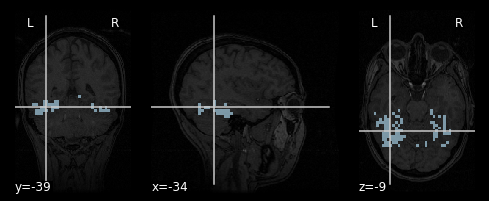

In [3]:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background
from nilearn import plotting
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                 cmap='Paired')

Now we use the NiftiMasker.

We first create a masker, giving it the options that we care
about. Here we use standardizing of the data, as it is often important
for decoding



In [4]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_filename, standardize=True)

# We give the masker a filename and retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_filename)

The variable "fmri_masked" is a numpy array:



Its shape corresponds to the number of time-points times the number of
voxels in the mask



In [5]:
print(fmri_masked.shape)

(1452, 464)


At this point, our voxels are activation intensties. Some of the signal they encompass is Noise, while some is true signal. 1452 is the number of timepoints where an the image was recorded, regarless of whether some stimuli was invoked or now, thus we have 464 voxels to consider in this regard for each timepoint. Lets see the activation pattern for the first voxel 


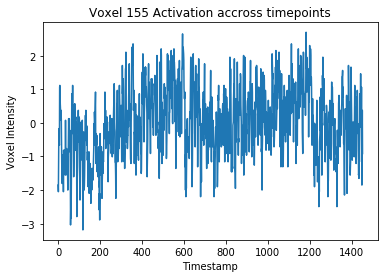

In [6]:
random_voxel = np.random.randint(464)
activation = [vox[random_voxel] for vox in fmri_masked]
time = [i for i in range(len(fmri_masked))]
plt.title(f"Voxel {random_voxel} Activation accross timepoints")
plt.ylabel("Voxel Intensity")
plt.xlabel("Timestamp")
plt.plot(time, activation)


We know that most of the variance in this is explained by Noise. What we will do is make use of PCA to find the principal component that explains the most variance in intensity. To do this, we will perform PCA decomposition on the voxel data. We will restructure the data, flattening it before performng PCA on it. This will allow us to make use of Scikit learn's in build tools.

Given that we cannot isolate the first component on Its own, what we will do is reconstruct the data based on the first principal component only, and then find the difference between the reconstruction and the original data.


In [7]:
flattened_data = fmri_masked.flatten().reshape(-1,1)

In [8]:
from sklearn.decomposition import PCA
model =  PCA(.80)
reduced = model.fit_transform(flattened_data)
pca_reduced_data = model.inverse_transform(reduced)

Assuming the component we just extracted is purely Noise, the difference between it and the original data should contain mostly True signal.

In [9]:
difference = flattened_data - pca_reduced_data

We will next plot the two side by side to see what the differences are. To do this, we will decode the data using an SVM and then plot it. This is in correspondence to the tutorial here: 
https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html

(216,)
[0.59722222 0.80555556 0.55555556]


/Users/brianwahome254/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


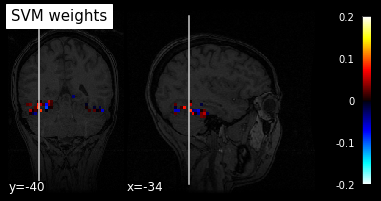

In [10]:
import pandas as pd
# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']

condition_mask = conditions.isin(['face', 'cat'])

# We apply this mask in the sampe direction to restrict the
# classification to the face vs cat discrimination
fmri_masked = fmri_masked[condition_mask]

conditions = conditions[condition_mask]
print(conditions.shape)

from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(fmri_masked, conditions)
prediction = svc.predict(fmri_masked)

from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(svc, fmri_masked, conditions)
print(cv_score)
coef_ = svc.coef_
coef_img = masker.inverse_transform(coef_)
coef_img.to_filename('haxby_svc_weights1.nii.gz')
from nilearn.plotting import plot_stat_map, show

plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
              title="SVM weights", display_mode="yx")

show()

Repeat the same analysis with the PCA difference data data.

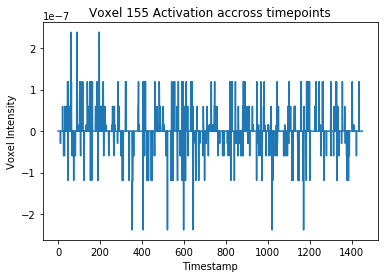

In [11]:
#Reshape the data
difference_fmri_masked = difference.reshape((1452,464))

activation = [vox[random_voxel] for vox in difference_fmri_masked]
time = [i for i in range(len(difference_fmri_masked))]
plt.title(f"Voxel {random_voxel} Activation accross timepoints")
plt.ylabel("Voxel Intensity")
plt.xlabel("Timestamp")
plt.plot(time, activation)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
[0.5        0.51388889 0.5       ]
['/Users/brianwahome254/nilearn_data/haxby2001/subj2/anat.nii.gz']


/Users/brianwahome254/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


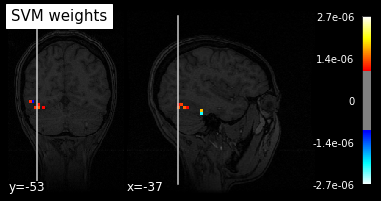

In [12]:
difference_fmri_masked = difference_fmri_masked[condition_mask]

svc1 = SVC(kernel='linear')
print(svc1)
svc1.fit(difference_fmri_masked, conditions)
prediction = svc1.predict(difference_fmri_masked)


cv_score = cross_val_score(svc1, difference_fmri_masked, conditions)
print(cv_score)
coef_1 = svc1.coef_
coef_img1 = masker.inverse_transform(coef_1)
coef_img1.to_filename('haxby_svc_weights2.nii.gz')

plot_stat_map(coef_img1, bg_img=haxby_dataset.anat[0],
              title="SVM weights", display_mode="yx")

show()